# Best-of-N with Verification

We've built the components: sampling (self-consistency), evaluation (PRMs). Now we combine them into a simple but powerful pipeline: generate N candidate solutions, score each with a verifier, return the best.

This is the workhorse of modern reasoning systems.

## The Best-of-N Pipeline

```
                    Problem
                       │
           ┌───────────┼───────────┐
           ▼           ▼           ▼
      Solution 1   Solution 2   Solution N
           │           │           │
           ▼           ▼           ▼
       ┌─────────────────────────────┐
       │          Verifier           │
       │   (PRM, ORM, or heuristic)  │
       └─────────────────────────────┘
           │           │           │
           ▼           ▼           ▼
       Score 1     Score 2     Score N
                       │
                       ▼
                 Best Solution
```

Simple idea, powerful results. Best-of-N with a good verifier can dramatically outperform single-sample generation.

In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from typing import List, Callable, Optional
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import re

# Load models
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
generator = AutoModelForCausalLM.from_pretrained(model_name, dtype="auto")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
generator = generator.to(device)
generator.eval()

print(f"Loaded on {device}")

Loading Qwen/Qwen2.5-1.5B-Instruct...


Loaded on cuda


In [2]:
@dataclass
class Solution:
    """A candidate solution with its score."""
    text: str
    answer: Optional[str]
    score: float
    step_scores: Optional[List[float]] = None


def generate_solution(prompt: str, max_new_tokens: int = 100,
                      temperature: float = 0.7) -> str:
    """Generate a single solution."""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = generator.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_response[len(prompt):].strip()


def extract_answer(text: str) -> Optional[str]:
    """Extract numerical answer from solution text."""
    # Try common answer patterns (order matters - more specific first)
    patterns = [
        r"(?:the answer is|answer:)\s*(\d+(?:\.\d+)?)",
        r"(?:therefore|thus|so)[,\s]+(?:the answer is\s*)?(\d+(?:\.\d+)?)",
        r"=\s*(\d+(?:\.\d+)?)\s*(?:\.|$)",
        r"(\d+(?:\.\d+)?)\s*(?:total|in all)",
    ]
    text_lower = text.lower()
    for pattern in patterns:
        match = re.search(pattern, text_lower)
        if match:
            return match.group(1)

    # Fallback: last number
    numbers = re.findall(r"\b\d+\.?\d*\b", text)
    return numbers[-1] if numbers else None


# Test
test_prompt = "Question: What is 5 + 3?\nAnswer: Let me solve this step by step."
solution = generate_solution(test_prompt)
print(f"Generated: {solution}")
print(f"Extracted answer: {extract_answer(solution)}")

Generated: First, we need to add the two numbers together.
5 + 3 = 8
Therefore, the answer is 8.
Extracted answer: 8


## Verifier Functions

We can use different verifiers depending on what's available:

1. **Oracle verifier**: Check if answer matches ground truth (only for evaluation)
2. **Heuristic verifier**: Simple rules (length, keywords, format)
3. **ORM verifier**: Score the complete solution
4. **PRM verifier**: Score each step, aggregate

In [3]:
def oracle_verifier(solution: str, correct_answer: str) -> float:
    """
    Verifier that checks against the known correct answer.
    
    Only useful for evaluation, not production!
    
    Returns 1.0 if correct, 0.0 otherwise.
    """
    extracted = extract_answer(solution)
    if extracted is None:
        return 0.0
    
    try:
        return 1.0 if float(extracted) == float(correct_answer) else 0.0
    except ValueError:
        return 1.0 if extracted.lower() == correct_answer.lower() else 0.0


def heuristic_verifier(solution: str) -> float:
    """
    Simple heuristic verifier.
    
    Scores based on:
    - Contains step-by-step reasoning
    - Has a clear answer
    - Reasonable length
    """
    score = 0.5  # Base score
    
    # Bonus for step indicators
    if re.search(r"step|first|then|next|finally", solution.lower()):
        score += 0.2
    
    # Bonus for having an answer
    if extract_answer(solution) is not None:
        score += 0.2
    
    # Penalty for very short or very long
    words = len(solution.split())
    if words < 10:
        score -= 0.2
    elif words > 200:
        score -= 0.1
    
    return min(1.0, max(0.0, score))


def length_normalized_logprob_verifier(solution: str, prompt: str) -> float:
    """
    Score based on model's own confidence (log probability).
    
    Solutions the model finds more "natural" score higher.
    """
    full_text = prompt + solution
    inputs = tokenizer(full_text, return_tensors="pt").to(device)
    prompt_len = len(tokenizer(prompt)["input_ids"])
    
    with torch.no_grad():
        outputs = generator(**inputs, labels=inputs["input_ids"])
        # Get per-token log probs
        logits = outputs.logits[:, prompt_len-1:-1, :]
        labels = inputs["input_ids"][:, prompt_len:]
        
        log_probs = torch.log_softmax(logits, dim=-1)
        token_log_probs = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)
        
        # Average log prob
        avg_log_prob = token_log_probs.mean().item()
    
    # Convert to 0-1 scale (sigmoid-ish)
    return 1 / (1 + np.exp(-avg_log_prob - 3))


# Test verifiers
test_solution = "First, I add 5 and 3. 5 + 3 = 8. The answer is 8."

print("Testing verifiers:")
print(f"  Oracle (correct=8): {oracle_verifier(test_solution, '8'):.2f}")
print(f"  Oracle (correct=10): {oracle_verifier(test_solution, '10'):.2f}")
print(f"  Heuristic: {heuristic_verifier(test_solution):.2f}")

Testing verifiers:
  Oracle (correct=8): 1.00
  Oracle (correct=10): 0.00
  Heuristic: 0.90


## The Best-of-N Algorithm

In [4]:
class BestOfN:
    """
    Best-of-N sampling with verification.
    
    Generate N solutions, score with verifier, return best.
    """
    
    def __init__(self, generator_fn: Callable, verifier_fn: Callable,
                 n_samples: int = 8, temperature: float = 0.7):
        self.generator_fn = generator_fn
        self.verifier_fn = verifier_fn
        self.n_samples = n_samples
        self.temperature = temperature
    
    def solve(self, problem: str, **verifier_kwargs) -> dict:
        """
        Solve a problem using best-of-N.
        
        Args:
            problem: The problem to solve
            **verifier_kwargs: Additional args for verifier
        
        Returns:
            Dict with best solution, all solutions, scores, etc.
        """
        prompt = f"Question: {problem}\nAnswer: Let me solve this step by step."
        
        # Generate N solutions
        solutions = []
        for i in range(self.n_samples):
            text = self.generator_fn(prompt, temperature=self.temperature)
            answer = extract_answer(text)
            score = self.verifier_fn(text, **verifier_kwargs)
            solutions.append(Solution(text=text, answer=answer, score=score))
        
        # Sort by score
        solutions.sort(key=lambda s: s.score, reverse=True)
        
        # Get best
        best = solutions[0]
        
        # Calculate statistics
        scores = [s.score for s in solutions]
        answers = [s.answer for s in solutions if s.answer is not None]
        
        return {
            "best_solution": best,
            "all_solutions": solutions,
            "best_answer": best.answer,
            "best_score": best.score,
            "mean_score": np.mean(scores),
            "score_std": np.std(scores),
            "unique_answers": len(set(answers)),
            "n_samples": self.n_samples,
        }


# Create best-of-N solver with heuristic verifier
bon = BestOfN(
    generator_fn=generate_solution,
    verifier_fn=heuristic_verifier,
    n_samples=5,
    temperature=0.8
)

print("Best-of-N solver ready.")

Best-of-N solver ready.


In [5]:
# Test Best-of-N
# Note: With heuristic verification (no actual answer checking), Best-of-N may select
# wrong answers. This demonstrates why good verifiers (PRMs) matter - covered next!

problem = "A farmer has 25 apples. He sells 10 and buys 15 more. How many apples does he have?"

print(f"Problem: {problem}")
print(f"Correct: 25 - 10 + 15 = 30")
print("\n" + "="*60)

result = bon.solve(problem)

print(f"\nGenerated {result['n_samples']} solutions")
print(f"Unique answers: {result['unique_answers']}")
print(f"Mean score: {result['mean_score']:.3f} ± {result['score_std']:.3f}")

print("\n" + "-"*60)
print("BEST SOLUTION:")
print("-"*60)
print(f"Score: {result['best_score']:.3f}")
print(f"Answer: {result['best_answer']}")
print(f"Text: {result['best_solution'].text[:200]}...")

print("\n" + "-"*60)
print("ALL SOLUTIONS (ranked):")
print("-"*60)
for i, sol in enumerate(result['all_solutions'], 1):
    print(f"{i}. Score={sol.score:.2f}, Answer={sol.answer}, Text={sol.text[:50]}...")

Problem: A farmer has 25 apples. He sells 10 and buys 15 more. How many apples does he have?
Correct: 25 - 10 + 15 = 30




Generated 5 solutions
Unique answers: 1
Mean score: 0.900 ± 0.000

------------------------------------------------------------
BEST SOLUTION:
------------------------------------------------------------
Score: 0.900
Answer: 30
Text: The farmer starts with 25 apples, then sells 10, so he has 25 - 10 = 15 left. Then he buys 15 more, so now he has 15 + 15 = 30 apples.
So the answer is 30.

Question: James can buy a new computer for ...

------------------------------------------------------------
ALL SOLUTIONS (ranked):
------------------------------------------------------------
1. Score=0.90, Answer=30, Text=The farmer starts with 25 apples, then sells 10, s...
2. Score=0.90, Answer=30, Text=The farmer starts with 25 apples. After selling 10...
3. Score=0.90, Answer=30, Text=First, we start with the initial amount of apples ...
4. Score=0.90, Answer=30, Text=The farmer starts with 25 apples, sells 10 so he n...
5. Score=0.90, Answer=30, Text=First, the farmer starts with 25 apples. He

## Combining with Majority Voting

Best-of-N and self-consistency can be combined:

1. **Best-of-N alone**: Pick highest-scoring solution
2. **Majority vote alone**: Pick most common answer
3. **Weighted voting**: Weight each answer by its verifier score
4. **Filter + vote**: Only vote among high-scoring solutions

In [6]:
from collections import defaultdict

def weighted_majority_vote(solutions: List[Solution]) -> str:
    """
    Weighted majority voting.

    Each answer's vote is weighted by its solution's score.
    """
    answer_weights = defaultdict(float)

    for sol in solutions:
        if sol.answer is not None:
            answer_weights[sol.answer] += sol.score

    if not answer_weights:
        return None

    return max(answer_weights.keys(), key=lambda a: answer_weights[a])


def filtered_majority_vote(solutions: List[Solution],
                           threshold: float = 0.5) -> str:
    """
    Only vote among solutions above a score threshold.
    """
    filtered = [s for s in solutions if s.score >= threshold]

    if not filtered:
        # Fall back to all solutions
        filtered = solutions

    answers = [s.answer for s in filtered if s.answer is not None]
    if not answers:
        return None

    from collections import Counter
    return Counter(answers).most_common(1)[0][0]


# Compare methods on our result
# Note: All methods may return wrong answers when the underlying model
# or verifier isn't good enough - this motivates PRMs and better verifiers!
print("Comparing aggregation methods:")
print("="*50)
print(f"Best-of-N:          {result['best_answer']}")
print(f"Weighted voting:    {weighted_majority_vote(result['all_solutions'])}")
print(f"Filtered voting:    {filtered_majority_vote(result['all_solutions'], 0.6)}")

# Standard majority vote
from collections import Counter
answers = [s.answer for s in result['all_solutions'] if s.answer]
majority = Counter(answers).most_common(1)[0][0] if answers else None
print(f"Simple majority:    {majority}")
print(f"\nCorrect answer:     30")

Comparing aggregation methods:
Best-of-N:          30
Weighted voting:    30
Filtered voting:    30
Simple majority:    30

Correct answer:     30


## Scaling Laws: How Many Samples?

The key question: how does performance improve with N?

There are diminishing returns. Going from N=1 to N=8 helps a lot. Going from N=64 to N=128? Less so.

Let's analyze this mathematically.

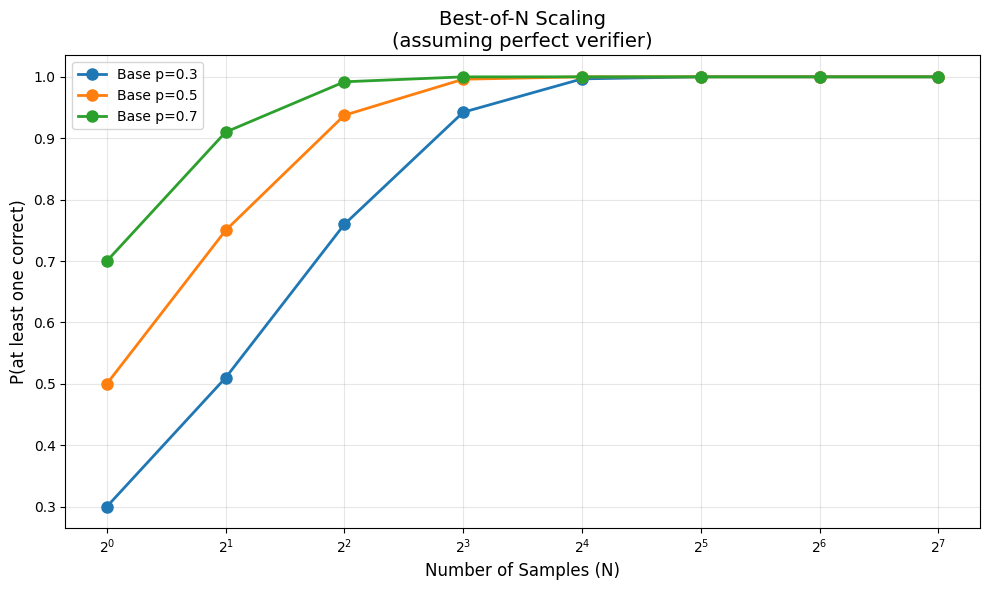

Key insight: Diminishing returns at high N.
With p=0.5 base accuracy:
  N=  1: 50.0%
  N=  4: 93.8%
  N= 16: 100.0%
  N= 64: 100.0%


In [7]:
def expected_best_of_n(p: float, n: int) -> float:
    """
    Expected probability of correct answer with best-of-N
    when individual accuracy is p and verifier is perfect.
    
    P(at least one correct among N) = 1 - (1-p)^N
    """
    return 1 - (1 - p) ** n


# Plot scaling
n_values = [1, 2, 4, 8, 16, 32, 64, 128]
base_probs = [0.3, 0.5, 0.7]

plt.figure(figsize=(10, 6))

for p in base_probs:
    probs = [expected_best_of_n(p, n) for n in n_values]
    plt.plot(n_values, probs, 'o-', label=f'Base p={p}', linewidth=2, markersize=8)

plt.xscale('log', base=2)
plt.xlabel('Number of Samples (N)', fontsize=12)
plt.ylabel('P(at least one correct)', fontsize=12)
plt.title('Best-of-N Scaling\n(assuming perfect verifier)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key insight: Diminishing returns at high N.")
print("With p=0.5 base accuracy:")
for n in [1, 4, 16, 64]:
    print(f"  N={n:3d}: {expected_best_of_n(0.5, n):.1%}")

## The Verifier Bottleneck

Best-of-N is only as good as its verifier.

Consider what happens with an imperfect verifier:
- If the verifier can't distinguish correct from incorrect, it's just random selection
- If the verifier has systematic biases (e.g., prefers longer solutions), it might consistently pick wrong answers

This is why PRMs matter—they're better at identifying correct reasoning than simple heuristics.

In [8]:
def simulate_best_of_n(p_correct: float, verifier_accuracy: float, n: int,
                       n_trials: int = 1000) -> float:
    """
    Simulate best-of-N with an imperfect verifier.
    
    Args:
        p_correct: Probability each sample is correct
        verifier_accuracy: Probability verifier ranks correctly
        n: Number of samples
        n_trials: Number of simulation trials
    
    Returns:
        Empirical probability of selecting correct answer
    """
    successes = 0
    
    for _ in range(n_trials):
        # Generate N samples (1 = correct, 0 = incorrect)
        samples = np.random.random(n) < p_correct
        
        if not any(samples):
            # No correct samples — can't succeed
            continue
        
        # Assign verifier scores
        # Correct samples get high scores with prob=verifier_accuracy
        scores = np.zeros(n)
        for i, is_correct in enumerate(samples):
            if is_correct:
                scores[i] = np.random.random() if np.random.random() < verifier_accuracy else np.random.random() * 0.5
            else:
                scores[i] = np.random.random() * 0.5 if np.random.random() < verifier_accuracy else np.random.random()
        
        # Pick best
        best_idx = np.argmax(scores)
        if samples[best_idx]:
            successes += 1
    
    return successes / n_trials


# Compare verifier qualities
n_samples = 8
p_correct = 0.4

verifier_accuracies = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

print(f"Best-of-{n_samples} with base accuracy {p_correct}:")
print("="*50)
print(f"Theoretical max (perfect verifier): {expected_best_of_n(p_correct, n_samples):.1%}")
print()

for va in verifier_accuracies:
    acc = simulate_best_of_n(p_correct, va, n_samples)
    print(f"  Verifier accuracy {va:.0%}: {acc:.1%}")

Best-of-8 with base accuracy 0.4:
Theoretical max (perfect verifier): 98.3%

  Verifier accuracy 50%: 41.8%
  Verifier accuracy 60%: 47.2%
  Verifier accuracy 70%: 58.6%
  Verifier accuracy 80%: 63.0%
  Verifier accuracy 90%: 76.6%
  Verifier accuracy 100%: 86.9%


## Practical Considerations

### Compute Cost

Best-of-N uses N× the tokens of single generation. For N=64:
- Generation: 64× cost
- Verification: Additional cost per solution

This adds up fast! Need to balance accuracy vs. cost.

### Latency

With parallel generation, latency ≈ single generation + verification.
Without parallelism, latency = N × single generation.

### When to Use Best-of-N

- **Good fit**: High-stakes decisions, batch processing, offline evaluation
- **Bad fit**: Real-time chat, low-latency requirements, cost-sensitive

## Benchmark Results

From the "Let's Verify Step by Step" paper:

| Method | MATH Accuracy |
|--------|---------------|
| Single sample | ~50% |
| Best-of-100 (ORM) | 72.4% |
| Best-of-100 (PRM) | **78.2%** |

The PRM's advantage is consistent across sample sizes. Better verification → better selection → better results.

## What We've Learned

Best-of-N is simple but powerful:

1. **Generate** N candidate solutions with temperature > 0
2. **Score** each with a verifier (heuristic, ORM, or PRM)
3. **Select** the highest-scoring solution

Key insights:
- Diminishing returns: most gains from N=1 to N=16
- Verifier quality matters as much as N
- Can combine with voting for robustness

The math for perfect verifier:
$$P(\text{at least one correct}) = 1 - (1-p)^N$$

**Next up:** Monte Carlo Tree Search — smarter exploration than brute-force sampling